In [1]:
%pylab inline
import pandas as pd
bb_info = pd.read_csv("computed_my_COCO_BBvals.csv")

Populating the interactive namespace from numpy and matplotlib


In [5]:
from analysis_toolbox import *

# Overall Distribution 

In [311]:
def plot_fitted_worker_histo(fcn):
    metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
    NUM_PLOTS = len(metrics_lst)
    NUM_ROW = 2
    NUM_COL = NUM_PLOTS/NUM_ROW

    fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_COL*2.5,NUM_ROW*3))#, sharex='col')
    stitle = fig.suptitle("Worker Metric Distribution [{}] ".format(fcn.name),fontsize=16,y=1.05)
    axs = axs.ravel()
    table_data = []
    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
        metric_value = np.array(bb_info[metric][bb_info[metric]>FILTER_CRITERION][bb_info[metric]<=1]) 
        ax = axs[i]
        ax.set_title(metric)
        #ax.hist(metric_value,bins=30)
        if metric in ["Num Points"]:
            metric_value = np.array(bb_info[metric])
            ax.set_xlim(0,metric_value.max())
        else:
            #restrict range [0,1] for normalized measures
            ax.set_xlim(0,1.03)
            metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        params = fcn.fit(metric_value)
        n, bins, patches = ax.hist(metric_value, 50, normed=1, facecolor='blue', alpha=0.75)
        y = fcn.pdf(bins, *params)
        l = ax.plot(bins, y, 'r--', linewidth=2) 
    fig.tight_layout()
    fig.savefig('{}_fitted_metric_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])


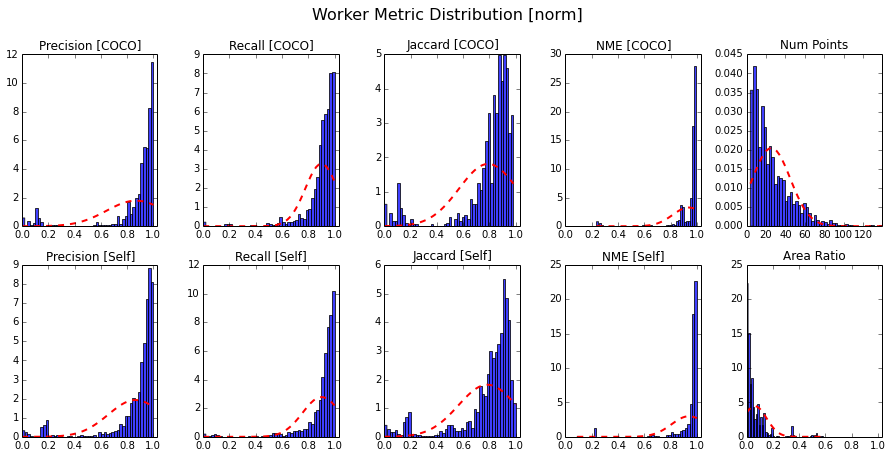

In [250]:
plot_fitted_worker_histo(scipy.stats.norm)

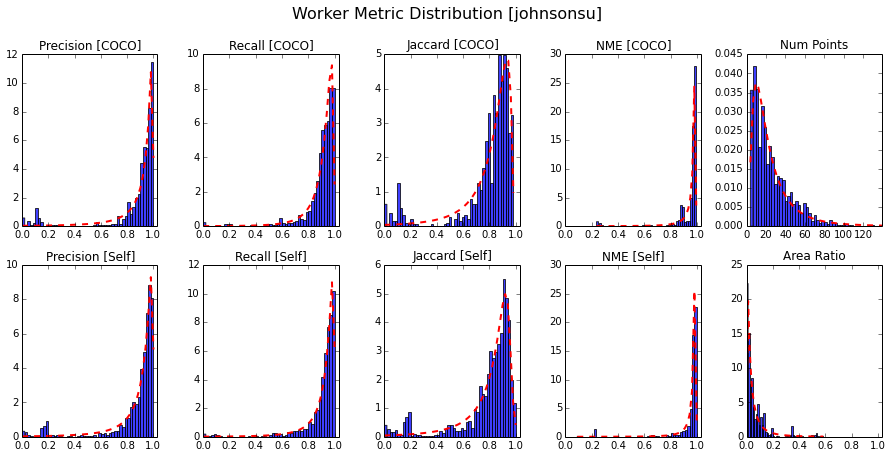

In [171]:
plot_fitted_worker_histo(scipy.stats.johnsonsu)

In [233]:
def compute_all_stats(FILTER_CRITERION=0.):
    '''
    Compute the basic stats of all metrics and store it in a table format (table_data)
    '''    
    table_data = []
    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
        if metric in ["Num Points","Area Ratio"]:
            metric_value = np.array(bb_info[metric])
        else:
            #restrict range [0,1] for normalized measures
            metric_value = np.array(bb_info[metric][bb_info[metric]>FILTER_CRITERION][bb_info[metric]<=1]) 
        table_data.append(basic_stat(metric_value,metric,PRINT=False))
    if FILTER_CRITERION==0:
        print tabulate(table_data,headers=["All","Mean","SD"],showindex="False",tablefmt='latex',floatfmt='.2g')
    else:
        print tabulate(table_data,headers=["Filter>{}".format(FILTER_CRITERION),"Mean","SD"],showindex="False",tablefmt='latex',floatfmt='.2g')

Generating Table 1

In [234]:
compute_all_stats()
compute_all_stats(FILTER_CRITERION=0.6)

\begin{tabular}{lrr}
\hline
 All              &   Mean &     SD \\
\hline
 Precision [COCO] &  0.87  &  0.22  \\
 Recall [COCO]    &  0.9   &  0.12  \\
 Jaccard [COCO]   &  0.79  &  0.22  \\
 NME [COCO]       &  0.94  &  0.12  \\
 Num Points       & 26     & 19     \\
 Precision [Self] &  0.86  &  0.21  \\
 Recall [Self]    &  0.9   &  0.14  \\
 Jaccard [Self]   &  0.78  &  0.22  \\
 NME [Self]       &  0.94  &  0.13  \\
 Area Ratio       &  0.063 &  0.089 \\
\hline
\end{tabular}
\begin{tabular}{lrr}
\hline
 Filter\ensuremath{>}0.6       &   Mean &     SD \\
\hline
 Precision [COCO] &  0.93  &  0.069 \\
 Recall [COCO]    &  0.92  &  0.072 \\
 Jaccard [COCO]   &  0.86  &  0.084 \\
 NME [COCO]       &  0.96  &  0.055 \\
 Num Points       & 26     & 19     \\
 Precision [Self] &  0.92  &  0.076 \\
 Recall [Self]    &  0.93  &  0.074 \\
 Jaccard [Self]   &  0.86  &  0.086 \\
 NME [Self]       &  0.96  &  0.053 \\
 Area Ratio       &  0.063 &  0.089 \\
\hline
\end{tabular}


In [172]:
def compute_all_fittings():
    '''
    Compute all fitting coefficients 
    '''
    bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
    metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
    exclude= ['division', 'skellam', 'nbinom', 'logser', 'erlang','dlaplace', 'hypergeom', 'bernoulli', 'levy_stable', 'zipf', 'rv_discrete', 'rv_frozen', 'boltzmann', 'rv_continuous', 'entropy', 'randint', 'poisson', 'geom', 'binom', 'planck', 'print_function']
    data_fit_stats=[]
    for i,metric in tqdm(zip(range(len(metrics_lst)),metrics_lst)):
        if metric in ["Num Points"]:
            metric_value = np.array(bb_info[metric])
        else:
            #restrict range [0,1] for normalized measures
            metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        #Testing against various distributions 
        for fcn_name in filter(lambda x: x not in exclude,dir(stats.distributions)[9:]):
            # Based on MLE estimate for fitting
            try:
                fcn = getattr(scipy.stats,fcn_name)
                params = fcn.fit(metric_value)
                histo,bin_edges = np.histogram(metric_value, 50, normed=1)
                bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
                y = fcn.pdf(bins, *params)
                RSS =sum((histo-y)**2)
                ks_result = kolmogorov_smirnov(bins,y,fcn_name) #D-value and p-value
                data_stats  = [metric,fcn_name,params,RSS]
                data_stats.extend(ks_result)
                data_fit_stats.append(data_stats)
            except(AttributeError,NotImplementedError,TypeError):
                #function has no fitting
                print "Skipped", fcn_name
    df_stats_tbl = pd.DataFrame(data_fit_stats,columns=["metric","Function Name", "Parameters","RSS","D-value","p-value"])
    return df_stats_tbl

In [173]:
df_stats_tbl = compute_all_fittings()

  0%|          | 0/10 [00:00<?, ?it/s]

frechet_l : D = 0.26 ; p =0.06 ---> from same distribution
levy : D = 0.2 ; p =0.24 ---> from same distribution
nct : D = 0.26 ; p =0.06 ---> from same distribution
weibull_max : D = 0.26 ; p =0.06 ---> from same distribution

 10%|█         | 1/10 [00:26<04:01,  0.04it/s]


ncx2 : D = 0.26 ; p =0.06 ---> from same distribution
pareto : D = 0.2 ; p =0.24 ---> from same distribution
powerlognorm : D = 0.24 ; p =0.1 ---> from same distribution
wald : D = 0.26 ; p =0.06 ---> from same distribution

 20%|██        | 2/10 [00:49<03:17,  0.04it/s]


dweibull : D = 0.26 ; p =0.06 ---> from same distribution
levy : D = 0.22 ; p =0.15 ---> from same distribution

 30%|███       | 3/10 [01:09<02:42,  0.04it/s]


halfcauchy : D = 0.24 ; p =0.1 ---> from same distribution

 50%|█████     | 5/10 [01:59<01:59,  0.04it/s]


frechet_r : D = 0.24 ; p =0.1 ---> from same distribution
reciprocal : D = 0.22 ; p =0.15 ---> from same distribution
weibull_min : D = 0.24 ; p =0.1 ---> from same distribution

 60%|██████    | 6/10 [02:39<01:46,  0.04it/s]


frechet_l : D = 0.24 ; p =0.1 ---> from same distribution
frechet_r : D = 0.24 ; p =0.1 ---> from same distribution
wald : D = 0.26 ; p =0.06 ---> from same distribution
weibull_max : D = 0.24 ; p =0.1 ---> from same distribution
weibull_min : D = 0.24 ; p =0.1 ---> from same distribution

 70%|███████   | 7/10 [03:14<01:23,  0.04it/s]


beta : D = 0.2 ; p =0.24 ---> from same distribution
reciprocal : D = 0.2 ; p =0.24 ---> from same distribution

 80%|████████  | 8/10 [03:46<00:56,  0.04it/s]


exponweib : D = 0.26 ; p =0.06 ---> from same distribution
ncx2 : D = 0.18 ; p =0.36 ---> from same distribution
pareto : D = 0.2 ; p =0.24 ---> from same distribution
wald : D = 0.24 ; p =0.1 ---> from same distribution

 90%|█████████ | 9/10 [04:21<00:29,  0.03it/s]


invweibull : D = 0.22 ; p =0.15 ---> from same distribution

In [183]:
# sorted_df_stats_tbl = df_stats_tbl[df_stats_tbl["p-value"]>0.05].sort(["RSS","p-value"],ascending=[True,False])
# idx = sorted_df_stats_tbl.groupby(['metric'])['RSS'].transform(min) ==sorted_df_stats_tbl["RSS"]
# sorted_df_stats_tbl[idx]

Best fitting functions for each metric 

In [185]:
idx = df_stats_tbl.groupby(['metric'])['RSS'].transform(min) ==df_stats_tbl["RSS"]
df_stats_tbl[idx]

,metric,Function Name,Parameters,RSS,D-value,p-value
3,Precision [COCO],beta,"(94.9199240842, 0.969610078993, -7.84315798742...",9.113931,0.48,1.022699e-05
133,Recall [COCO],loggamma,"(0.0481347309123, 0.997966705501, 0.0046087175...",4.562850,0.46,2.763769e-05
200,Jaccard [COCO],gompertz,"(0.002288507401, 0.457472808578, 0.0711950705997)",13.312855,0.46,2.763769e-05
259,NME [COCO],cauchy,"(0.981588304686, 0.00865358537677)",51.670082,0.84,1.248758e-16
378,Num Points,johnsonsb,"(1.78906463355, 0.872683600529, 2.57126560216,...",0.000239,1.00,2.164688e-23
463,Precision [Self],johnsonsu,"(5.60677852705, 0.844861280829, 1.00448298037,...",6.826660,0.34,4.427949e-03
547,Recall [Self],johnsonsu,"(5.46750757986, 0.912177549296, 1.00526518455,...",5.494230,0.42,1.777837e-04
631,Jaccard [Self],johnsonsu,"(1.61491888233, 0.946641875046, 0.964153608486...",4.573405,0.28,3.166085e-02
679,NME [Self],cauchy,"(0.98156409667, 0.00925033988235)",35.632197,0.80,4.008887e-15
783,Area Ratio,gengamma,"(4.86158921952, 0.350470988837, 0.000438567258...",27.142858,0.34,4.427949e-03


#### Table 2 Best fitting functions

In [238]:
print tabulate(df_stats_tbl[idx].drop("Parameters",axis=1),showindex="False",headers='keys',tablefmt='latex',floatfmt='.3g')

\begin{tabular}{llrrr}
\hline
 metric           & Function Name   &       RSS &   D-value &   p-value \\
\hline
 Precision [COCO] & beta            &  9.11     &      0.48 &  1.02e-05 \\
 Recall [COCO]    & loggamma        &  4.56     &      0.46 &  2.76e-05 \\
 Jaccard [COCO]   & gompertz        & 13.3      &      0.46 &  2.76e-05 \\
 NME [COCO]       & cauchy          & 51.7      &      0.84 &  1.25e-16 \\
 Num Points       & johnsonsb       &  0.000239 &      1    &  2.16e-23 \\
 Precision [Self] & johnsonsu       &  6.83     &      0.34 &  0.00443  \\
 Recall [Self]    & johnsonsu       &  5.49     &      0.42 &  0.000178 \\
 Jaccard [Self]   & johnsonsu       &  4.57     &      0.28 &  0.0317   \\
 NME [Self]       & cauchy          & 35.6      &      0.8  &  4.01e-15 \\
 Area Ratio       & gengamma        & 27.1      &      0.34 &  0.00443  \\
\hline
\end{tabular}


#### Table 3: Johnson SU fitting results 

In [194]:
johnsonsu_tbl = df_stats_tbl[df_stats_tbl['Function Name']=='johnsonsu'].drop(['Parameters','Function Name'],axis=1)

In [221]:
bigpowtbl = df_stats_tbl[df_stats_tbl['Function Name']=='johnsonsu'].drop("Function Name",axis=1)
powtbl  = bigpowtbl['Parameters'].apply(pd.Series)
powtbl.columns =["xi","lambda","Shift","Scale"]
bigpowtbl = bigpowtbl.drop("Parameters",axis=1)

In [222]:
bigpowtbl.join(powtbl)

,metric,RSS,D-value,p-value,xi,lambda,Shift,Scale
43,Precision [COCO],10.040541,0.36,2.111951e-03,5.177937,0.750699,1.001447,0.000113
127,Recall [COCO],7.009698,0.44,7.159507e-05,5.913342,1.089807,1.006643,0.000617
211,Jaccard [COCO],13.537526,0.30,1.714441e-02,5.640332,1.115838,0.994723,0.001731
295,NME [COCO],217.919699,0.70,1.116526e-11,1.305715,0.612127,0.989977,0.003180
379,Num Points,0.000437,1.00,2.164688e-23,-6.229590,1.212153,0.795895,0.212017
463,Precision [Self],6.826660,0.34,4.427949e-03,5.606779,0.844861,1.004483,0.000184
547,Recall [Self],5.494230,0.42,1.777837e-04,5.467508,0.912178,1.005265,0.000290
631,Jaccard [Self],4.573405,0.28,3.166085e-02,1.614919,0.946642,0.964154,0.039441
715,NME [Self],107.279070,0.64,7.839819e-10,1.156889,0.614027,0.990525,0.003668
799,Area Ratio,30.389562,0.32,8.899159e-03,-4.900214,0.783876,-0.000196,0.000117


In [230]:
print tabulate(bigpowtbl.join(powtbl),showindex="False",headers='keys',tablefmt='latex',floatfmt='.2g')

\begin{tabular}{lrrrrrrr}
\hline
 metric           &      RSS &   D-value &   p-value &   xi &   lambda &   Shift &   Scale \\
\hline
 Precision [COCO] & 10       &      0.36 &   0.0021  &  5.2 &     0.75 &  1      & 0.00011 \\
 Recall [COCO]    &  7       &      0.44 &   7.2e-05 &  5.9 &     1.1  &  1      & 0.00062 \\
 Jaccard [COCO]   & 14       &      0.3  &   0.017   &  5.6 &     1.1  &  0.99   & 0.0017  \\
 NME [COCO]       &  2.2e+02 &      0.7  &   1.1e-11 &  1.3 &     0.61 &  0.99   & 0.0032  \\
 Num Points       &  0.00044 &      1    &   2.2e-23 & -6.2 &     1.2  &  0.8    & 0.21    \\
 Precision [Self] &  6.8     &      0.34 &   0.0044  &  5.6 &     0.84 &  1      & 0.00018 \\
 Recall [Self]    &  5.5     &      0.42 &   0.00018 &  5.5 &     0.91 &  1      & 0.00029 \\
 Jaccard [Self]   &  4.6     &      0.28 &   0.032   &  1.6 &     0.95 &  0.96   & 0.039   \\
 NME [Self]       &  1.1e+02 &      0.64 &   7.8e-10 &  1.2 &     0.61 &  0.99   & 0.0037  \\
 Area Ratio       & 

# $J_i$ distributions

In [68]:
plt.hist?

In [69]:
def plot_all_Ji_hist(fcn,SHOW_PLOT=10):
    '''
    Plot all worker distributions for each object 
    compute fitting coefficients for each Ji distribution
    show SHOW_PLOT number of sample plots
    '''
    bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
    obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [COCO]']!=0][bb_info['Jaccard [Self]']!=0].sort('object_id')
    object_id_lst  = list(set(obj_sorted_tbl.object_id))
    metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
    NUM_PLOTS = len(metrics_lst)
    NUM_ROW = 2
    NUM_COL = NUM_PLOTS/NUM_ROW
    data_fit_stats=[]
    for objid in object_id_lst:
        if SHOW_PLOT>0:
            fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_COL*2.5,NUM_ROW*3))
            stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
            axs = axs.ravel()
        # Ji_tbl (bb_info) is the set of all workers that annotated object i 
        bb  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
        for i,metric in zip(range(len(metrics_lst)),metrics_lst):
            if metric in ["Num Points"]:
                metric_value = np.array(bb[metric])
            else:
                #restrict range [0,1] for normalized measures
                metric_value = np.array(bb[metric][bb[metric]>0][bb[metric]<=1]) 
#             pltmin=metric_value.min()
#             pltmax=metric_value.max()

            params = fcn.fit(metric_value)
            histo,bin_edges = np.histogram(metric_value, 40, normed=1)#, range=(pltmin,pltmax))
            bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
            y = fcn.pdf(bins, *params)
            RSS =sum((histo-y)**2)
            ks_result = kolmogorov_smirnov(bins,y,fcn.name) #D-value and p-value
            # object_id, Metric, mu, sd,RSS,D-value,p-value
            data_stats  = [objid,metric,params[0],params[1],RSS,ks_result[0],ks_result[1]] 
            #same as what you would get if you did basic_stats because in the MLE estimate for Gaussians, mu and sigma is equal to sample mean and sample sd
            data_fit_stats.append(data_stats)
            
            if SHOW_PLOT>0:
                ax = axs[i]
                ax.set_title(metric)
#                ax.set_xlim(pltmin,pltmax)
                
                n, bins, patches = ax.hist(metric_value, 40, normed=1,facecolor='blue', alpha=0.75)
                y = fcn.pdf(bins, *params)
                l = ax.plot(bins, y, 'r--', linewidth=2) 

        if SHOW_PLOT>0: fig.tight_layout()
        SHOW_PLOT-=1
    fit_results =pd.DataFrame(data_fit_stats,columns=["object_id", "Metric", "Mean", "SD","RSS","D-value","p-value"])
    return fit_results

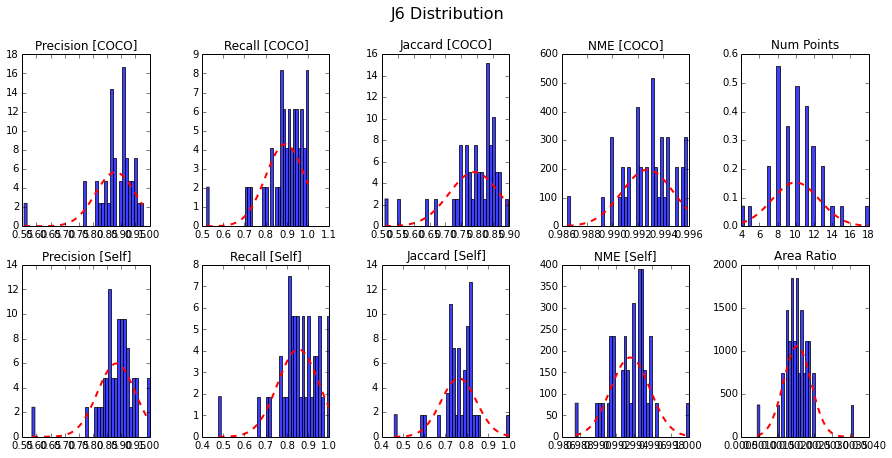

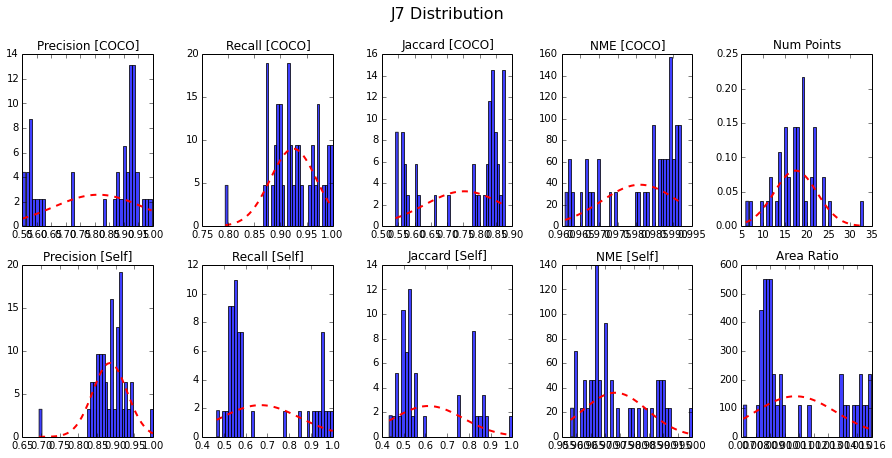

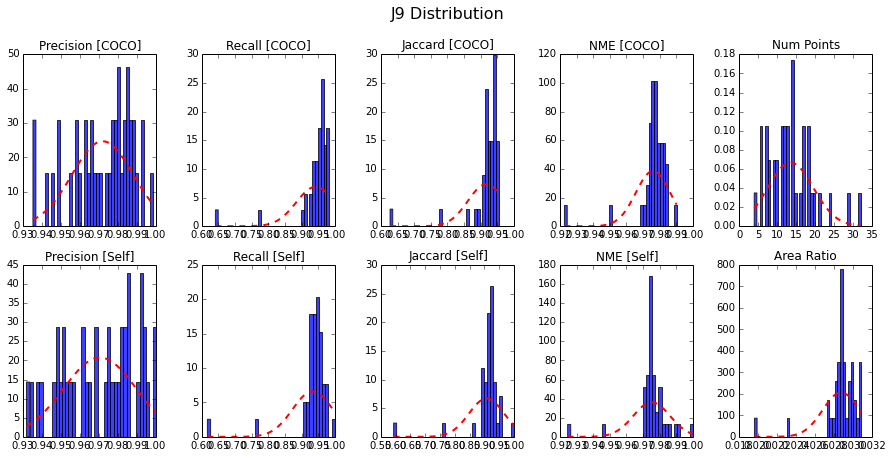

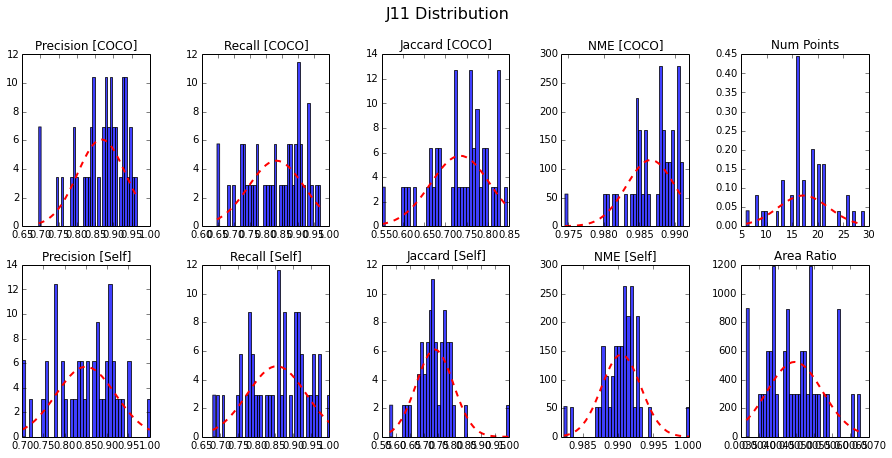

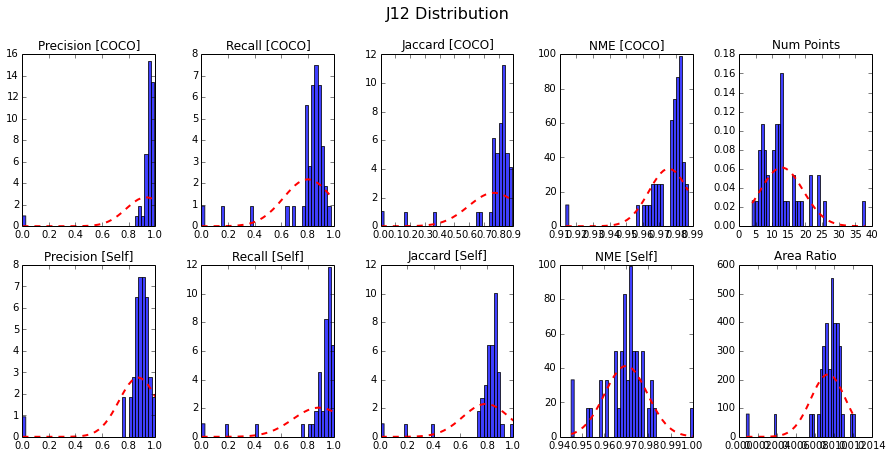

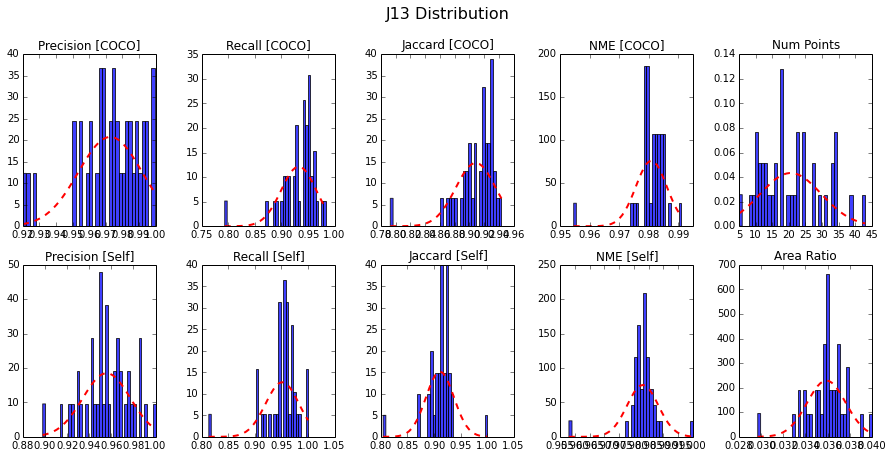

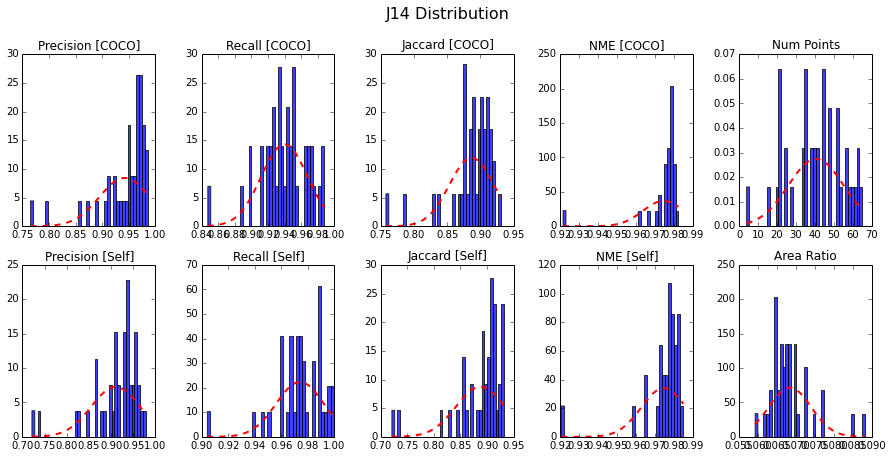

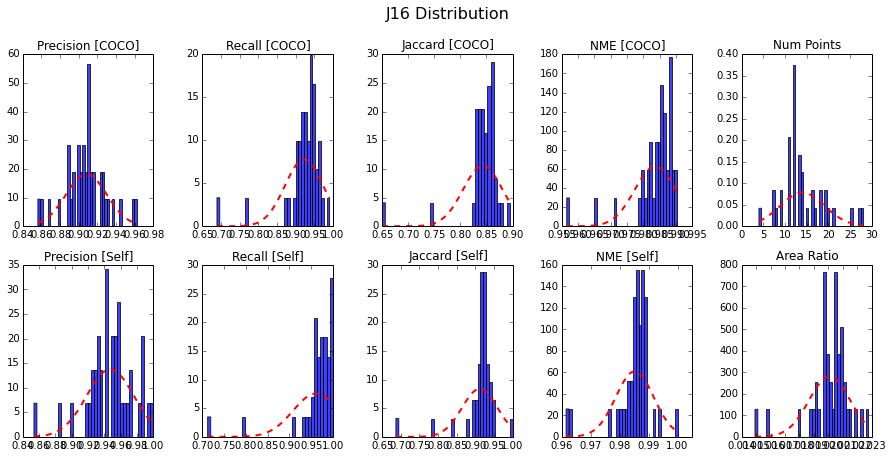

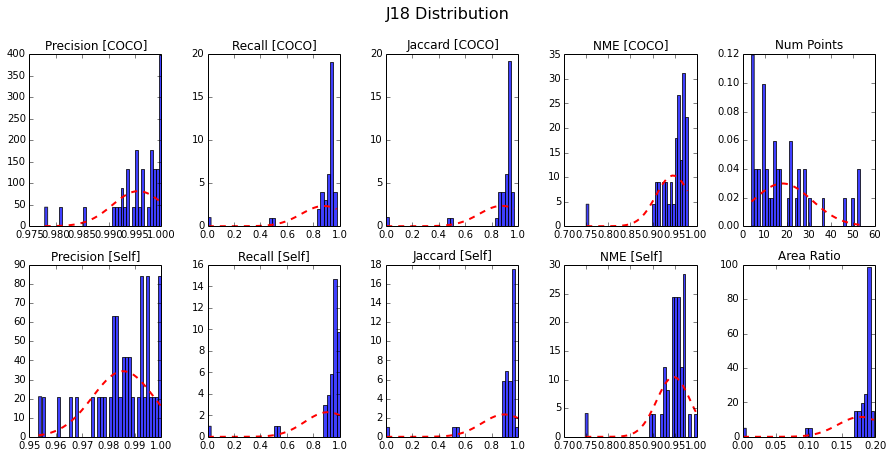

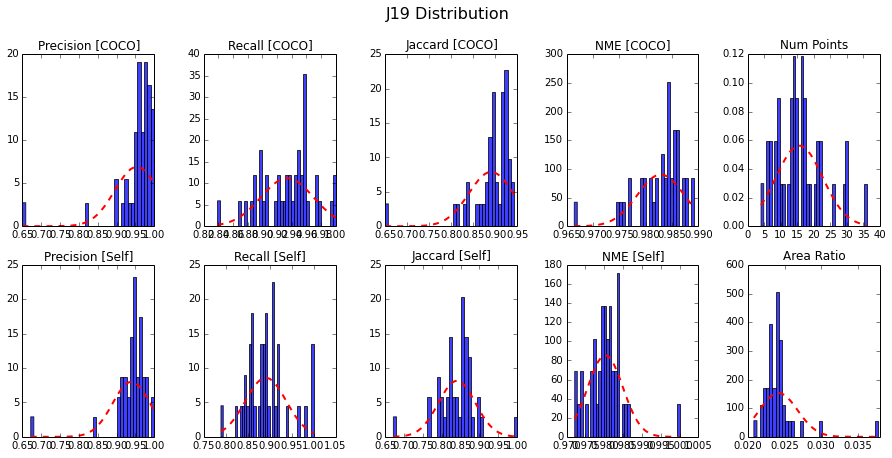

In [70]:
gaussian_fit_results = plot_all_Ji_hist(scipy.stats.norm)

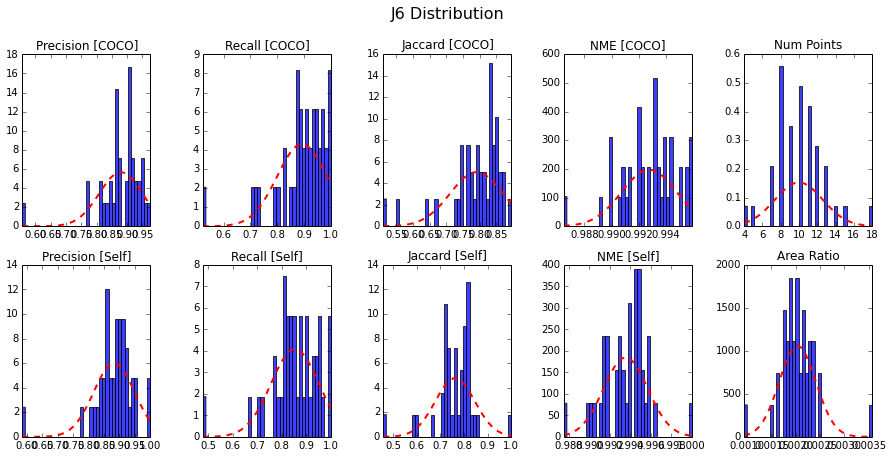

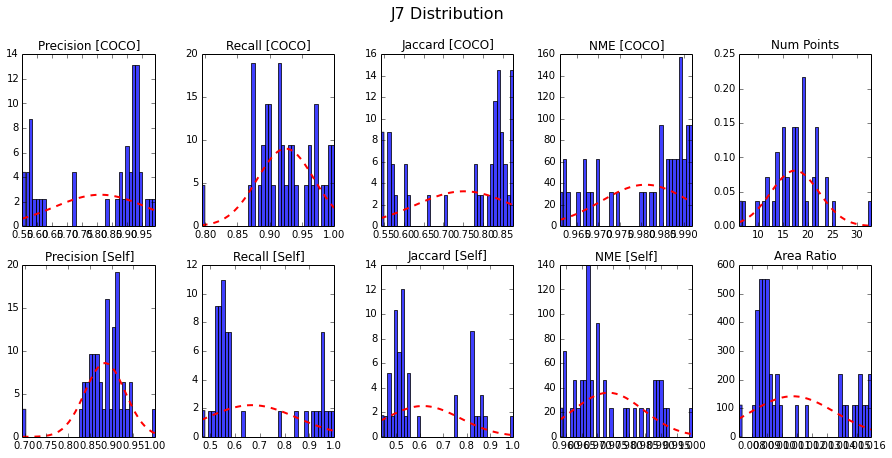

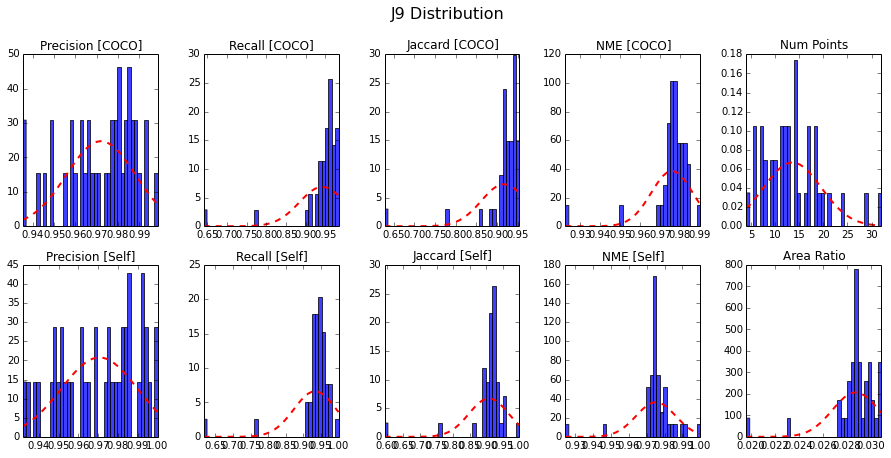

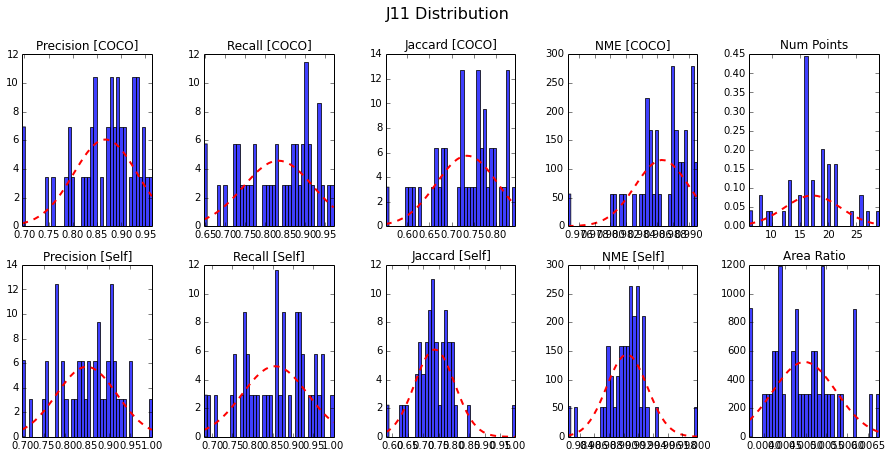

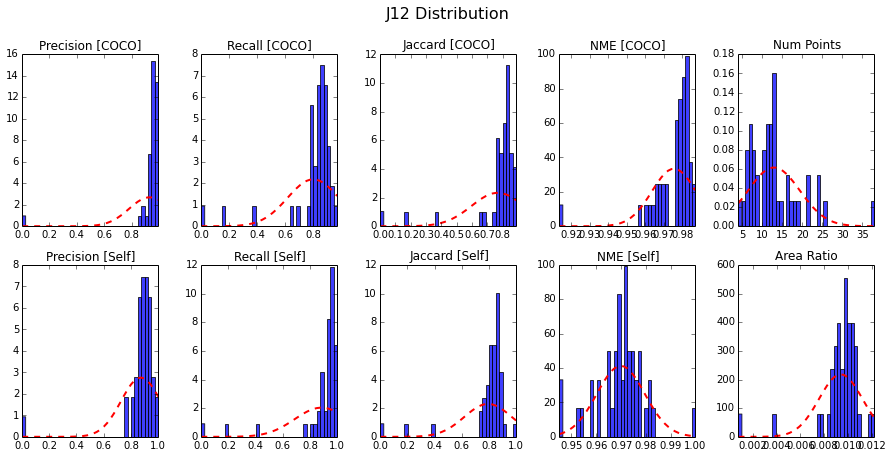

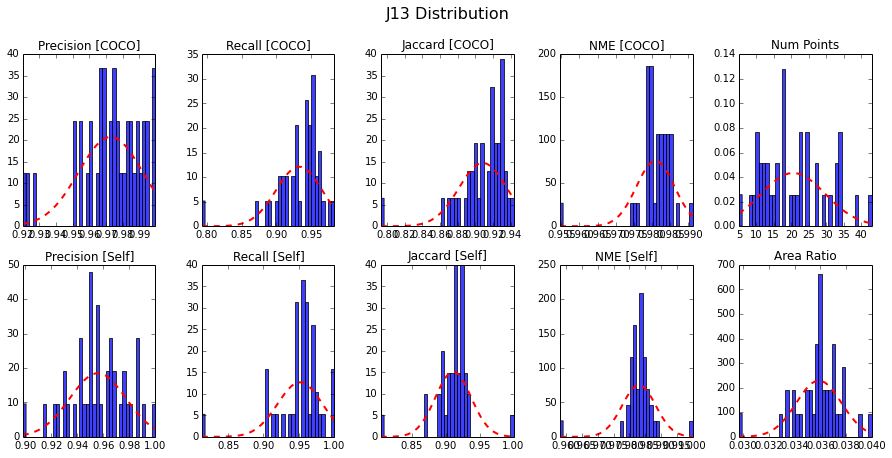

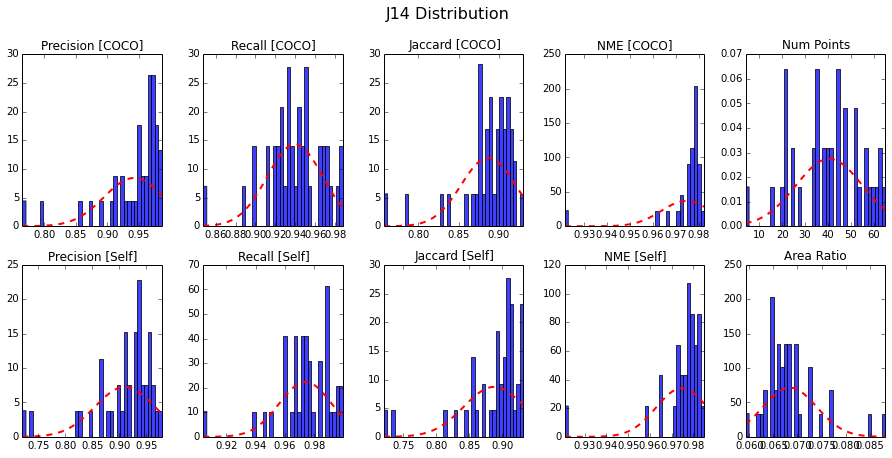

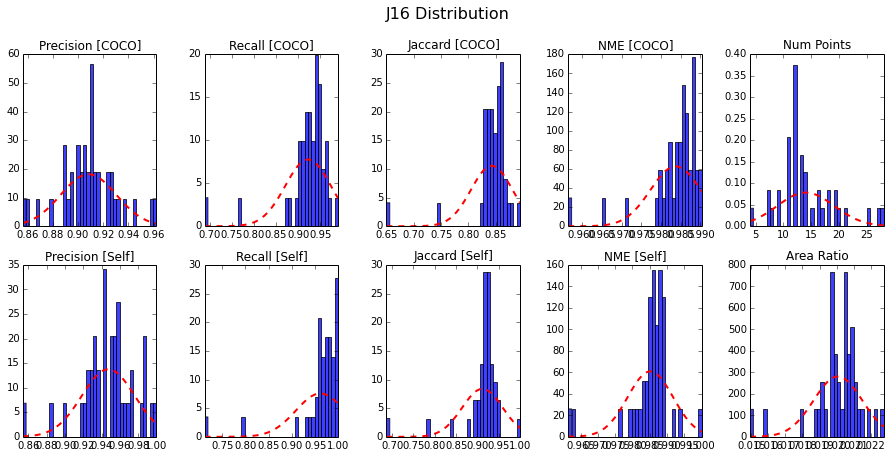

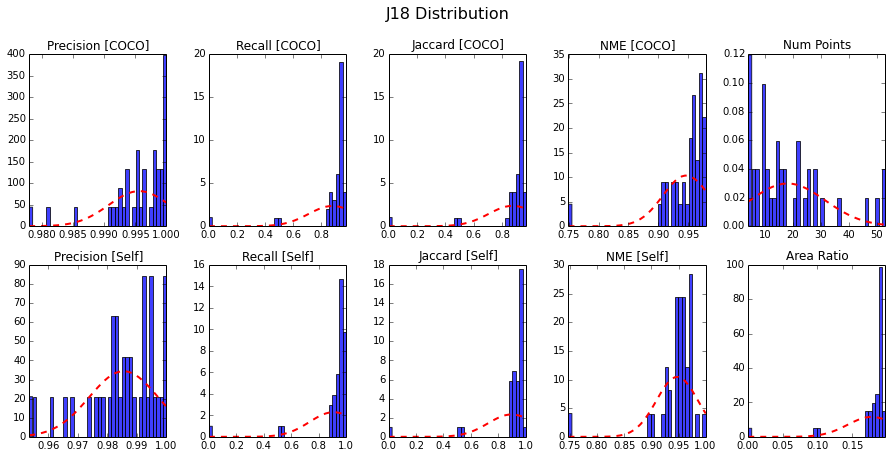

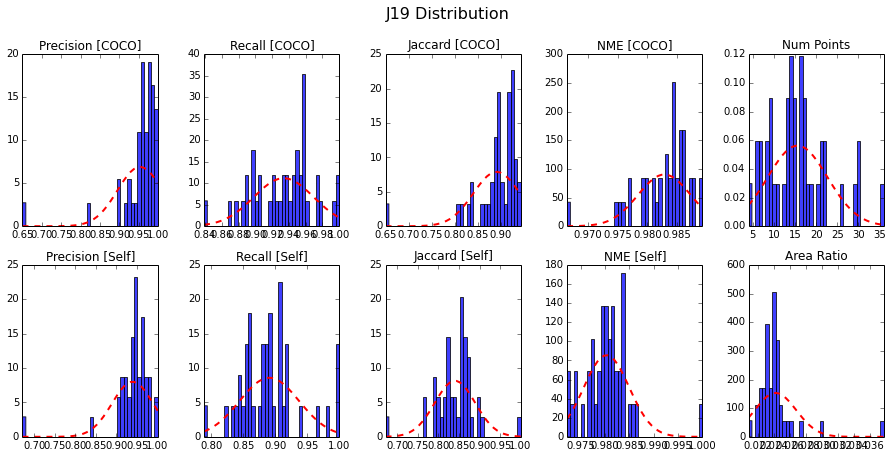

In [67]:
gaussian_fit_results = plot_all_Ji_hist(scipy.stats.norm)

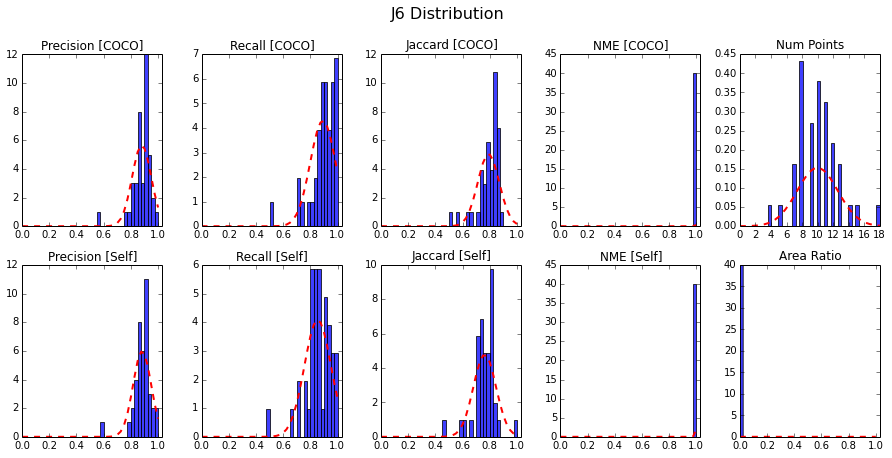

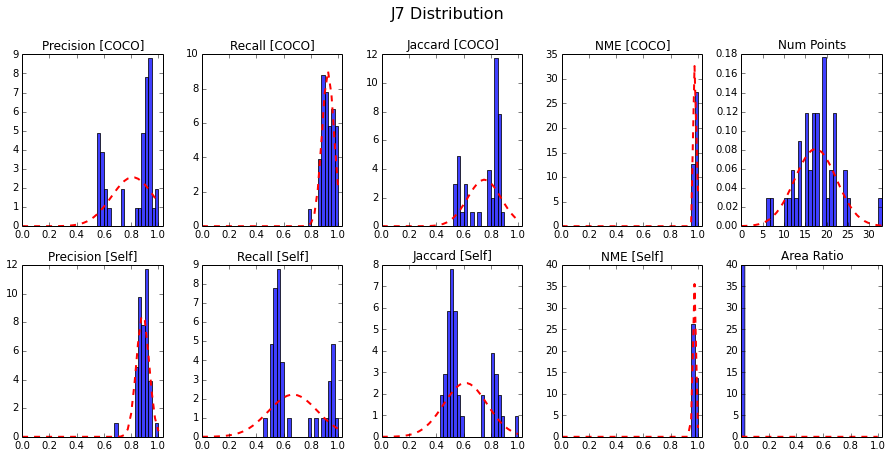

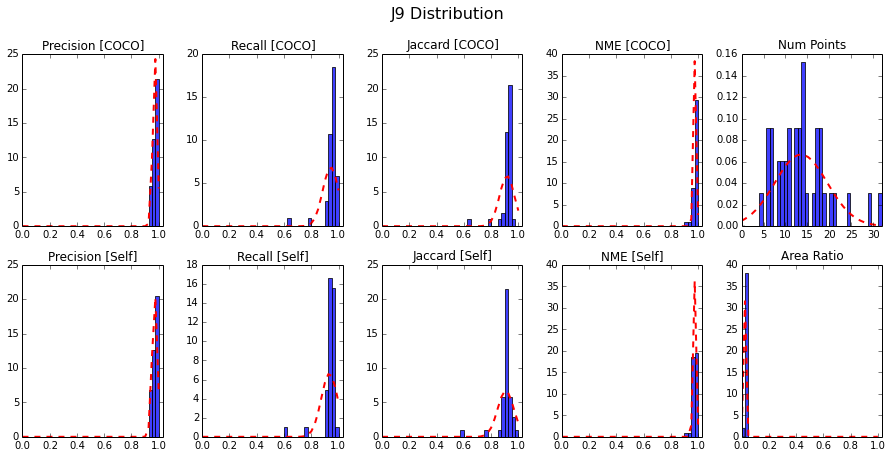

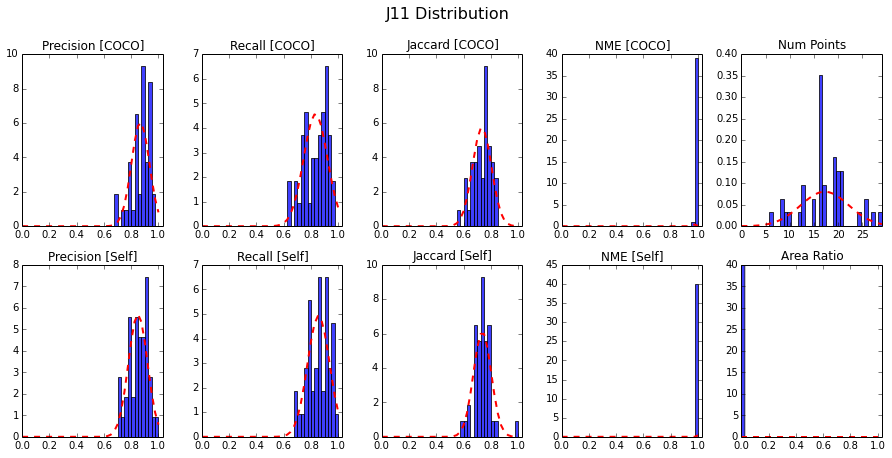

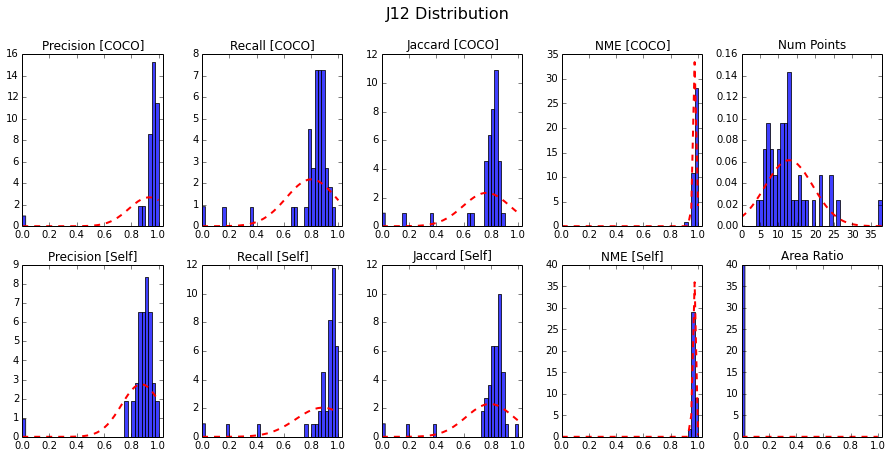

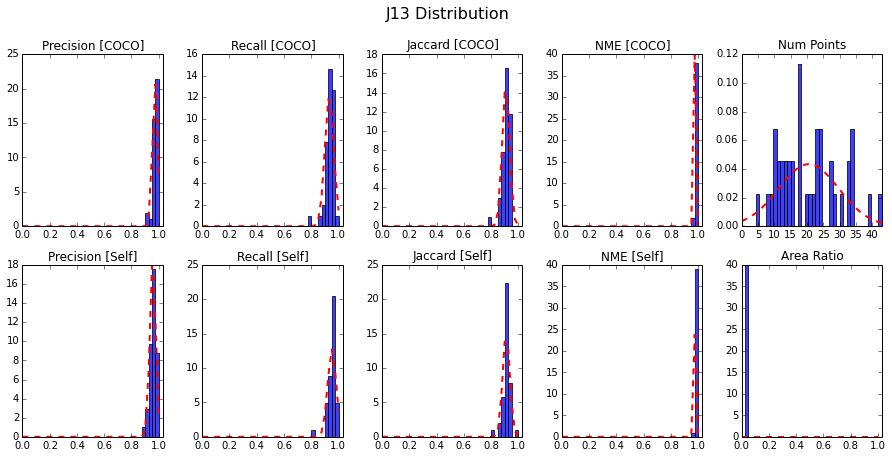

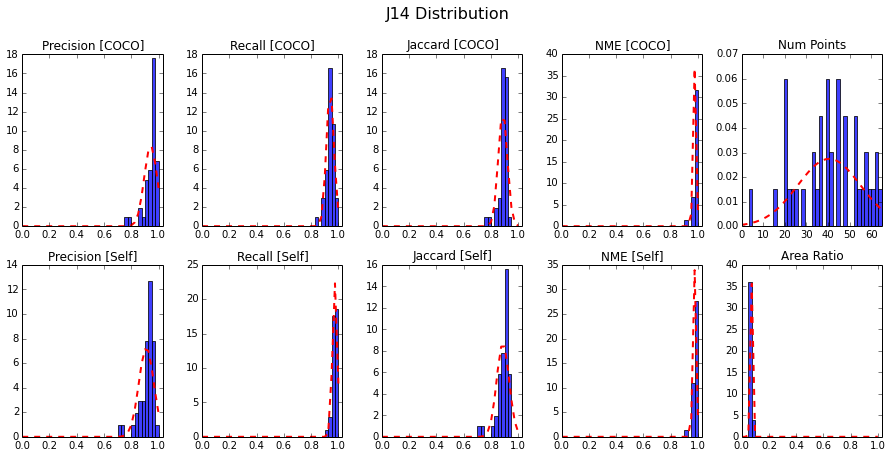

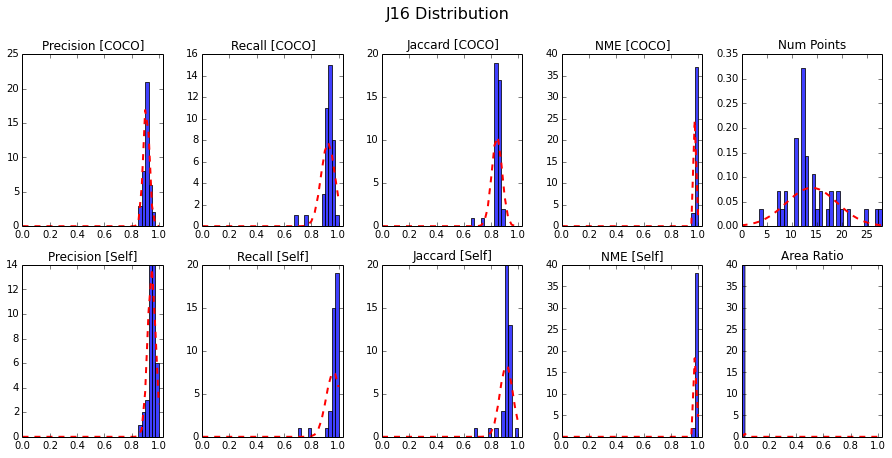

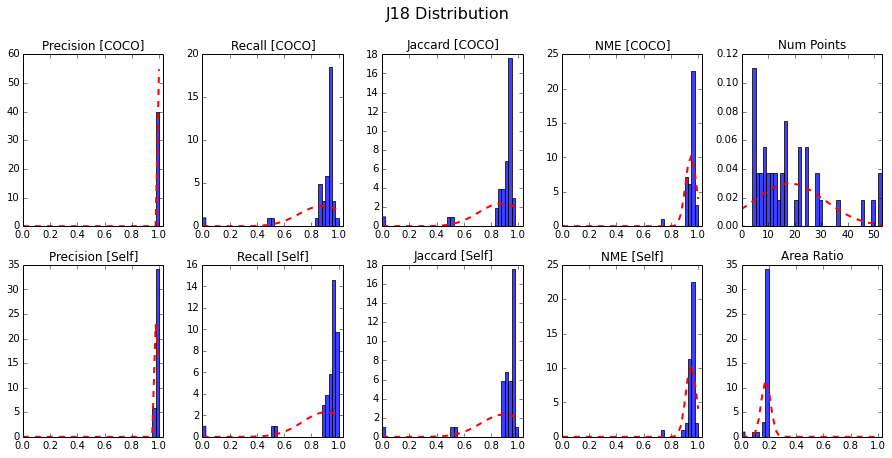

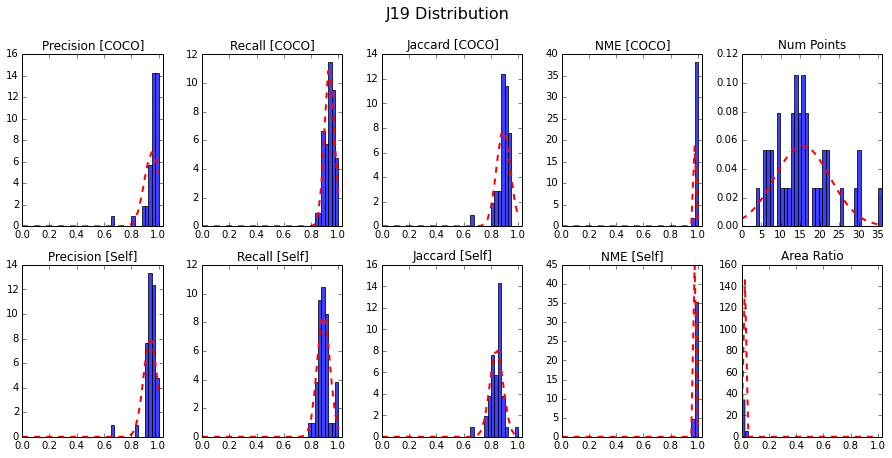

In [28]:
gaussian_fit_results = plot_all_Ji_hist(scipy.stats.norm)

In [29]:
gaussian_fit_results

,object_id,Metric,Mean,SD,RSS,D-value,p-value
0,6,Precision [COCO],0.879326,0.070482,322.737124,0.550,5.020623e-06
1,6,Recall [COCO],0.892419,0.092750,130.616799,0.550,5.020623e-06
2,6,Jaccard [COCO],0.790740,0.079216,298.677222,0.650,3.014130e-08
3,6,NME [COCO],0.992756,0.002021,585584.344555,1.000,6.133848e-19
4,6,Num Points,9.975610,2.608502,0.702615,1.000,6.133848e-19
5,6,Precision [Self],0.882656,0.066701,157.684846,0.575,1.513809e-06
6,6,Recall [Self],0.854184,0.097723,98.985412,0.600,4.327560e-07
7,6,Jaccard [Self],0.762723,0.083473,229.122473,0.525,1.578711e-05
8,6,NME [Self],0.993554,0.002159,300306.718437,1.000,6.133848e-19
9,6,Area Ratio,0.002039,0.000377,4462393.428338,1.000,6.133848e-19


In [30]:
#The fitting is not really statistically significant, average RSS is quite large too 
print gaussian_fit_results.RSS.mean()
print len(gaussian_fit_results[gaussian_fit_results["p-value"]>0.5])

74258.735928
0


In [ ]:
from tqdm import tqdm

In [62]:
def test_all_Ji_fit_fcn(fcns_to_test="all"):
    '''
    Test all function form against all Ji distributions, then return the fitting coefficients table
    '''
    if fcns_to_test=="all":
        exclude= ['division', 'skellam', 'nbinom', 'logser', 'erlang','dlaplace', 'hypergeom', 'bernoulli', 'levy_stable', 'zipf', 'rv_discrete', 'rv_frozen', 'boltzmann', 'rv_continuous', 'entropy', 'randint', 'poisson', 'geom', 'binom', 'planck', 'print_function']
        fcns_to_test = filter(lambda x: x not in exclude,dir(stats.distributions)[9:])
    bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
    obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [COCO]']!=0][bb_info['Jaccard [Self]']!=0].sort('object_id')
    object_id_lst  = list(set(obj_sorted_tbl.object_id))
    metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]

    NUM_PLOTS = len(metrics_lst)
    NUM_ROW = 2
    NUM_COL = NUM_PLOTS/NUM_ROW
    data_fit_stats=[]
    for objid in tqdm(object_id_lst):
        # Ji_tbl (bb_info) is the set of all workers that annotated object i 
        bb  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
        for i,metric in zip(range(len(metrics_lst)),metrics_lst):
            if metric in ["Num Points"]:
                metric_value = np.array(bb[metric])
                pltmax=metric_value.max()
            else:
                #restrict range [0,1] for normalized measures
                metric_value = np.array(bb[metric][bb[metric]>0][bb[metric]<=1]) 
                pltmax=1

            #Testing against various distributions 
            for fcn_name in fcns_to_test:
                fcn = getattr(stats,fcn_name)
                params = fcn.fit(metric_value)
                histo,bin_edges = np.histogram(metric_value, 40, normed=1)
                bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
                y = fcn.pdf(bins, *params)
                RSS =sum((histo-y)**2)
                ks_result = kolmogorov_smirnov(bins,y,fcn.name) #D-value and p-value
                # object_id, Metric, mu, sd,RSS,D-value,p-value
                data_stats  = [objid,fcn_name,metric,params[0],params[1],RSS,ks_result[0],ks_result[1]] 
                #same as what you would get if you did basic_stats because in the MLE estimate for Gaussians, mu and sigma is equal to sample mean and sample sd
                data_fit_stats.append(data_stats)
    fit_results =pd.DataFrame(data_fit_stats,columns=["object_id","Function", "metric", "Mean", "SD","RSS","D-value","p-value"])
    fit_results.to_csv("Ji_fit_results.csv")
    return fit_results

In [59]:
# will take about half an hour to run, consumes a lot of memory approx 12500 rows in pd table
# fit_results =test_all_Ji_fit_fcn()
# memory crashes about a quarter of the way there 
# 22%|█████████████████▏ | 5/23 [09:57<35:52, 0.01it/s]

In [60]:
idx = fit_results.groupby(['Metric'])['RSS'].transform(min) ==fit_results["RSS"]
fit_results[idx]

,object_id,Function,Metric,Mean,SD,RSS,D-value,p-value
147,6,powerlaw,Recall [COCO],2.568632,0.647553,75.889543,0.525,1.578711e-05
174,6,burr,Jaccard [COCO],1996701.897381,0.138045,182.273927,0.575,1.513809e-06
490,6,rice,Precision [Self],2.394311,0.759598,110.150786,0.475,1.330354e-04
883,7,johnsonsu,Precision [COCO],0.978965,0.544662,201.598379,0.450,3.565228e-04
1654,7,nct,Area Ratio,0.886511,1.830797,323603.061541,1.000,6.133848e-19
2011,9,vonmises_line,NME [COCO],3.545561,0.977684,3404.012967,0.575,1.513809e-06
2071,9,mielke,Num Points,1.400609,4.799737,0.057151,1.000,6.133848e-19
2224,9,invgauss,Recall [Self],0.023553,0.819568,61.424139,0.750,7.714369e-11
2311,9,johnsonsu,Jaccard [Self],0.231732,0.650057,108.857124,0.625,1.172933e-07
2395,9,johnsonsu,NME [Self],-0.246940,0.568834,3036.697322,0.625,1.172933e-07


In [61]:
fit_results[fit_results["p-value"]>0.5]

,object_id,Function,Metric,Mean,SD,RSS,D-value,p-value
977,7,lomax,Recall [COCO],7.217280e+08,0.794276,1877.237103,0.1,0.983366


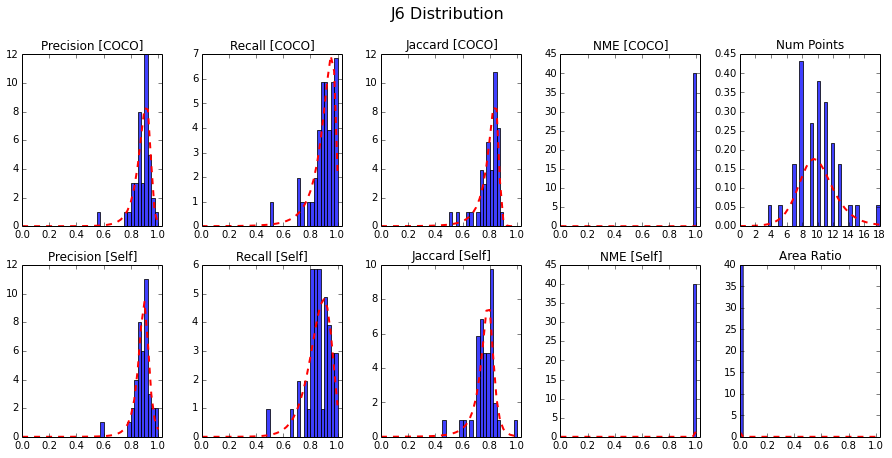

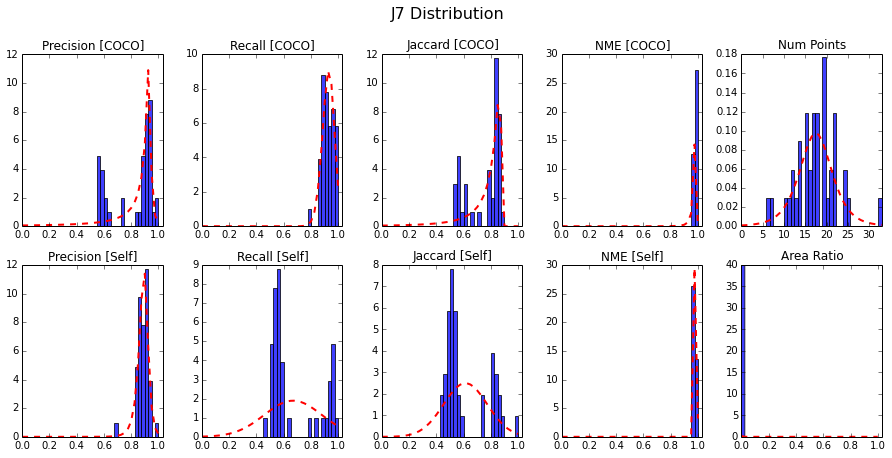

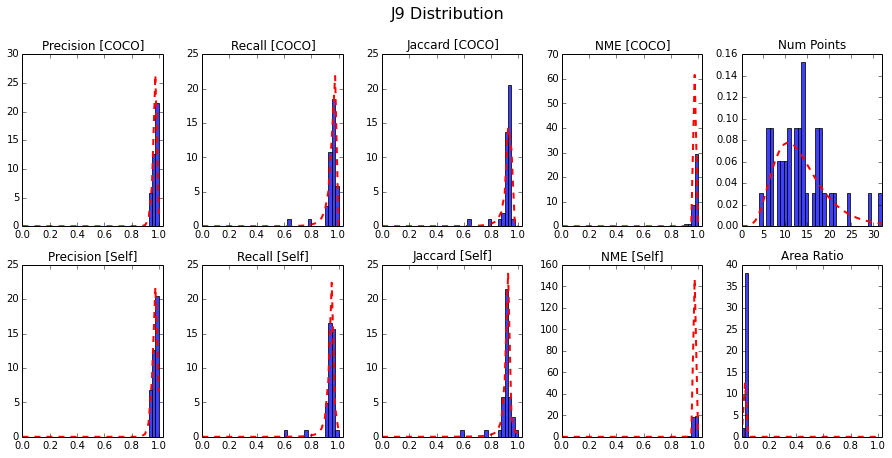

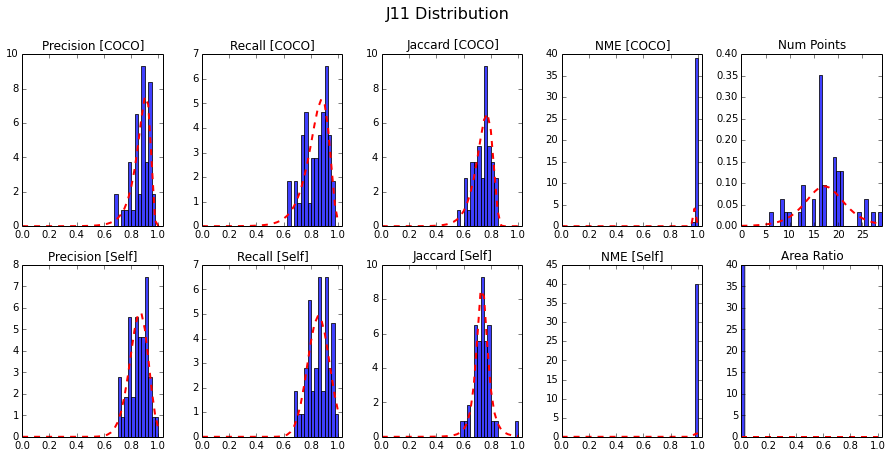

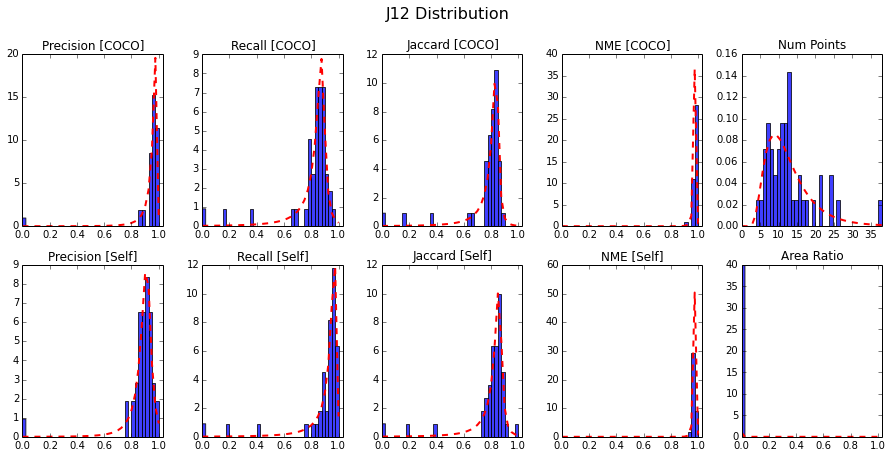

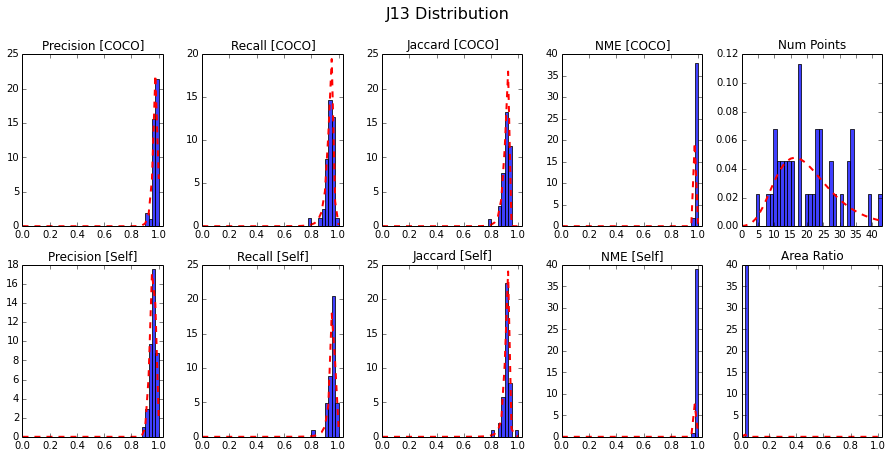

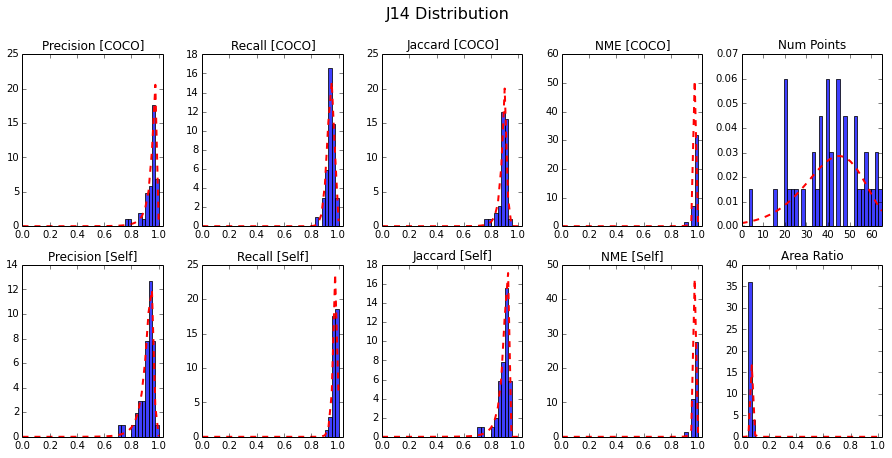

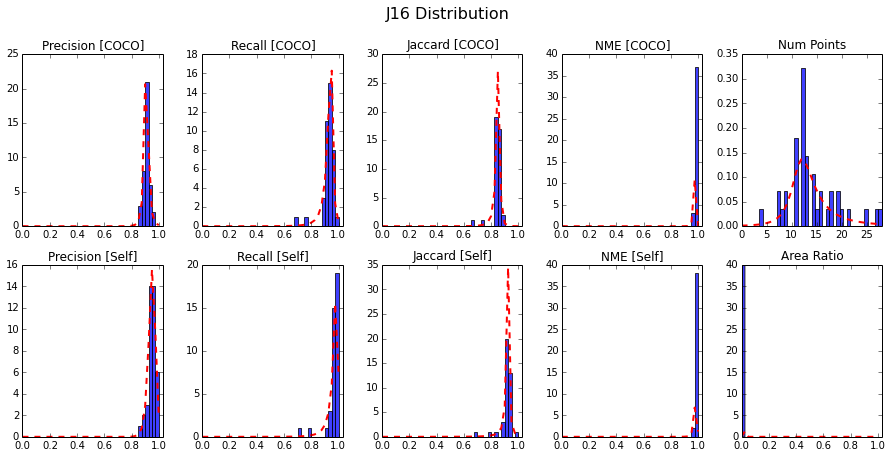

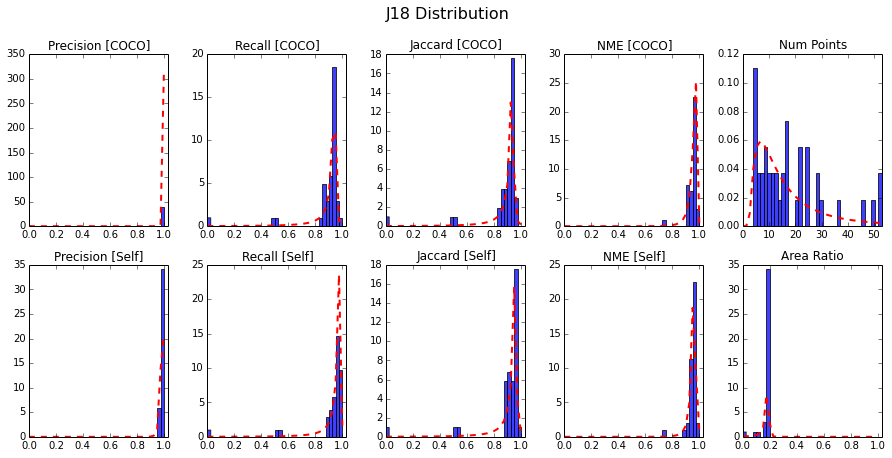

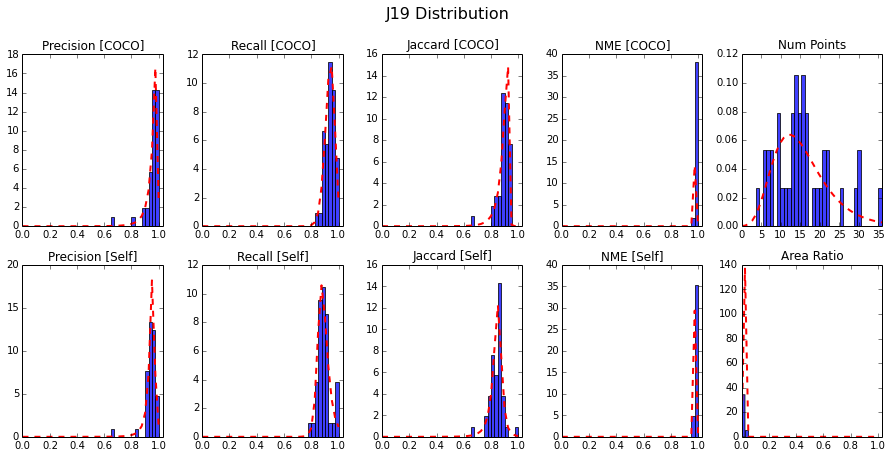

In [63]:
johnsonsu_fit_results = plot_all_Ji_hist(scipy.stats.johnsonsu)